In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from dateutil.parser import parse
from sklearn.metrics import mean_absolute_error 

In [20]:
# Read the dataset 
l = []
for i in os.listdir('files_input'):
    l.append(pd.read_csv(os.path.join('files_input', i)))

df = pd.concat(l, axis = 0) 

In [21]:
df.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,02-Jan-1995,0.0,0.0,0.0,1182.14,-,-
1,03-Jan-1995,0.0,0.0,0.0,1176.82,-,-
2,04-Jan-1995,0.0,0.0,0.0,1163.72,-,-
3,05-Jan-1995,0.0,0.0,0.0,1150.02,-,-
4,06-Jan-1995,0.0,0.0,0.0,1130.36,-,-


In [22]:
df.tail()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
241,24-Dec-2008,2967.40,2968.00,2900.45,2916.85,380460882,6975.71
242,26-Dec-2008,2919.85,2960.95,2844.80,2857.25,237935397,4558.9
243,29-Dec-2008,2857.15,2931.80,2812.90,2922.20,335171811,6367.55
244,30-Dec-2008,2922.55,2999.15,2899.75,2979.50,302749136,5819.5
245,31-Dec-2008,2979.80,3002.65,2937.35,2959.15,288826411,5707.75


In [23]:
def convert_str_to_date(in_date):
    return parse(in_date)

df['Date'] = df['Date'].apply(convert_str_to_date)

df.sort_values(by = ['Date'], axis = 0, ascending = True, inplace = True, na_position = 'last') 

df.reset_index(drop=True, inplace=True) 

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1, 1)) 

In [25]:
split_date = datetime.datetime(year=2022, month=1, day=1, hour=0)
df_train = df.loc[df['Date'] < split_date]
df_val = df.loc[df['Date'] >= split_date]

# Reset the indices of the validation set
df_val.reset_index(drop=True, inplace=True) 

In [26]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

X_train, y_train = makeXy(df_train['scaled_close'], 7)

X_val, y_val = makeXy(df_val['scaled_close'], 7)

#X_train and X_val are reshaped to 3D arrays
X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), X_val.reshape((X_val.shape[0], X_val.shape[1], 1)) 

In [27]:
from keras.layers import Dense, Input, Dropout

# from keras.layers.recurrent import LSTM # ModuleNotFoundError: No module named 'keras.layers.recurrent' # 20220826
from keras.layers import LSTM

from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(7,1), dtype='float32') 

In [28]:
lstm_layer1 = LSTM(64, input_shape=(7,1), return_sequences=True)(input_layer)
lstm_layer2 = LSTM(32, input_shape=(7,64), return_sequences=False)(lstm_layer1)

In [29]:
dropout_layer = Dropout(0.2)(lstm_layer2)

#Finally the output layer gives prediction.
output_layer = Dense(1, activation='linear')(dropout_layer) 

In [30]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')#SGD(lr=0.001, decay=1e-5))
ts_model.summary() 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [31]:
save_weights_at = os.path.join('files_1', 'models', 'p5', 'p5_nifty50_LSTM_weights.{epoch:02d}-{val_loss:.4f}.hdf5')

save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min', period=1)

ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=30, verbose=1, callbacks=[save_best], validation_data=(X_val, y_val), shuffle=True)

Epoch 1/30
434/434 [==============================] - 10s 13ms/step - loss: 0.0264 - val_loss: 0.0387
Epoch 2/30
434/434 [==============================] - 5s 10ms/step - loss: 0.0182 - val_loss: 0.0170
Epoch 3/30
434/434 [==============================] - 5s 10ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 4/30
434/434 [==============================] - 5s 10ms/step - loss: 0.0170 - val_loss: 0.0450
Epoch 5/30
434/434 [==============================] - 5s 10ms/step - loss: 0.0163 - val_loss: 0.0454
Epoch 6/30
434/434 [==============================] - 5s 10ms/step - loss: 0.0164 - val_loss: 0.0406
Epoch 7/30
434/434 [==============================] - 5s 11ms/step - loss: 0.0159 - val_loss: 0.0190
Epoch 8/30
434/434 [==============================] - 4s 10ms/step - loss: 0.0159 - val_loss: 0.0405
Epoch 9/30
434/434 [==============================] - 4s 10ms/step - loss: 0.0157 - val_loss: 0.0445
Epoch 10/30
434/434 [==============================] - 5s 11ms/step - loss: 0.0158 - val_l

In [32]:
best_model = load_model(os.path.join('files_1', 'models', 'p5', 'p5_nifty50_LSTM_weights.29-0.0102.hdf5'))
preds = best_model.predict(X_val)
pred = scaler.inverse_transform(preds)
pred = np.squeeze(pred)

mae = mean_absolute_error(df_val['Close'].loc[7:], pred)
print('MAE for the validation set:', round(mae, 4)) 

5/5 [==============================] - 1s 6ms/step
MAE for the validation set: 180.6436


Text(0.5, 0, 'Index')

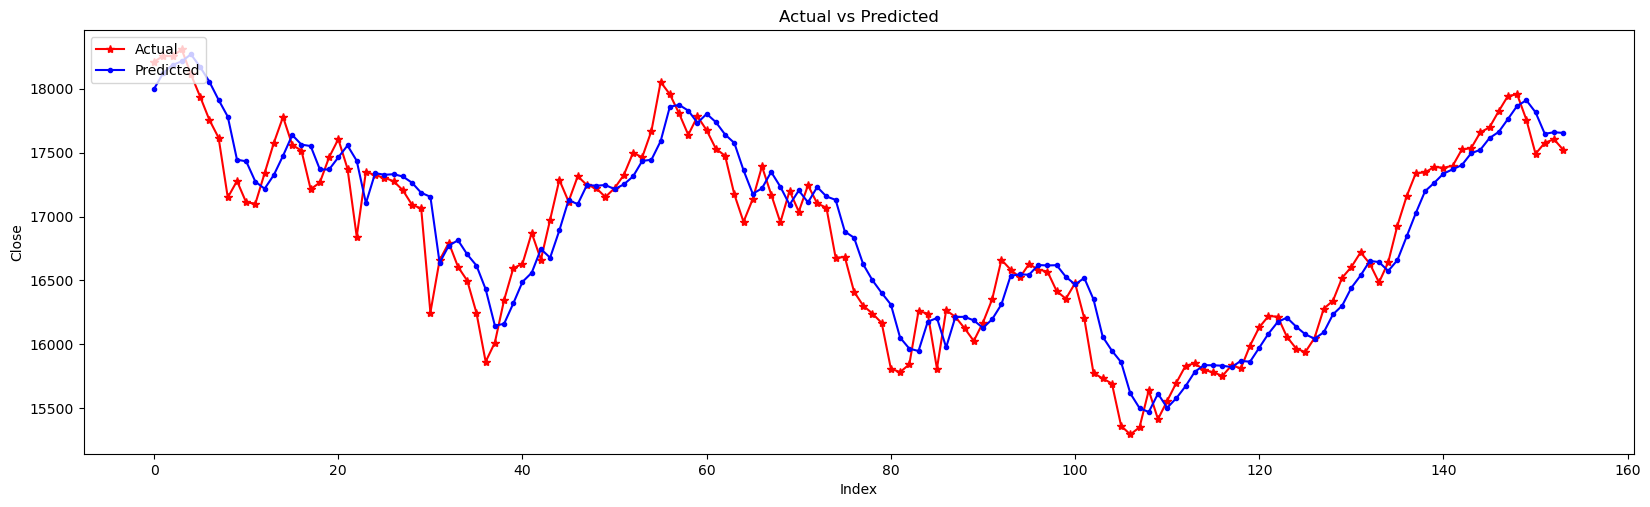

In [34]:
#Let's plot the actual and predicted values.
plt.figure(figsize=(20, 5.5))
plt.plot(range(len(df_val['Close'].loc[7:])), df_val['Close'].loc[7:], linestyle='-', marker='*', color='r')

plt.plot(range(len(df_val['Close'].loc[7:])), pred[:df_val.shape[0]], linestyle='-', marker='.', color='b')

plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted')
plt.ylabel('Close')
plt.xlabel('Index') 